In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from tqdm import tqdm


In [2]:
from astropy import units as un

In [3]:
import scifysim as sf

Building a model from scratch


## SCIFYsim started 

SCIFYsim is used mostly to generate a series of pointing representing an observing session. The object used here is HIP 101769 for its declination.

In [4]:
configfile = "/lhome/romain/Documents/hi5/SCIFYsim/scifysim/config/default_R400.ini"

WARNING-astroquery- UnitsWarning: Unit 'e' not supported by the VOUnit standard. 
WARNING-astroquery- UnitsWarning: Unit 'Sun' not supported by the VOUnit standard. Did you mean uN?
ERROR-scifysim.utilities- Couldn't find the entry in JSDC catalog


/lhome/romain/miniconda3/envs/math1/lib/python3.9/site-packages/astropy-5.0.1-py3.9-linux-x86_64.egg/astropy/units/equivalencies.py:89: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / x
/lhome/romain/Documents/hi5/SCIFYsim/scifysim/utilities.py:578: UserWarning: Warning: converting a masked element to nan.
  config.set("target", "star_radius", value="%.2f"%Rad)


Dist set to  inf [pc]
T set to  6485.2 [K]
R set to  -- [R_sun]


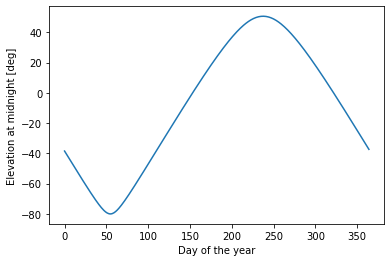

Best time: 2021-08-26T03:00:00.000
WARNING-astroquery- UnitsWarning: Unit 'e' not supported by the VOUnit standard. 
WARNING-astroquery- UnitsWarning: Unit 'Sun' not supported by the VOUnit standard. Did you mean uN?
Sequence start set to  2021-08-26T00:00:00.000
Sequence end set to  2021-08-26T06:00:00.000
WARNING-scifysim.director- tt_correction not implemented
WARNING-scifysim.director- no_piston not implemented
ERROR-scifysim.injection- Now we use fpath to provide the root for appendix config files
WARNING-scifysim.injection- Using same file for atmo configuration
WARNING-scifysim.injection- Needs a nice way to build pupils in here
WARNING-scifysim.injection- Hard-coded variables:


/lhome/romain/miniconda3/envs/math1/lib/python3.9/site-packages/astropy-5.0.1-py3.9-linux-x86_64.egg/astropy/units/equivalencies.py:89: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / x


0.010342691863670104
WARNING-scifysim.injection- Loading keyword step_time from [atmo] in fringe_tracking
WARNING-scifysim.injection- Preparing a fringe tracking residual time series
WARNING-scifysim.injection- Dry pistons and dispersion residuals scaling refreshed
sep =  4.5
pa =  60.0
offset =  (-3.8971143170299736, 2.2500000000000004)
WARNING-scifysim.combiner- Comuputed chromatic combiner matrix with the following shape:
WARNING-scifysim.combiner- (67, 8, 4)
inside_tuning [ 0.00000000e+00 -4.13720848e-08  0.00000000e+00 -4.13724906e-08] [ 0.         -0.00014521  0.         -0.00014521]


/lhome/romain/miniconda3/envs/math1/lib/python3.9/site-packages/astropy-5.0.1-py3.9-linux-x86_64.egg/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


WARNING-scifysim.combiner- Comuputed chromatic combiner matrix with the following shape:
WARNING-scifysim.combiner- (67, 8, 4)


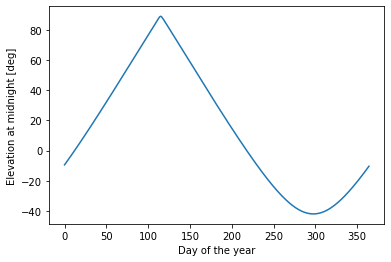

Best time: 2021-04-26T03:00:00.000
WARNING-astroquery- UnitsWarning: Unit 'e' not supported by the VOUnit standard. 
WARNING-astroquery- UnitsWarning: Unit 'Sun' not supported by the VOUnit standard. Did you mean uN?
Sequence start set to  2021-04-26T00:00:00.000
Sequence end set to  2021-04-26T06:00:00.000
WARNING-scifysim.director- tt_correction not implemented
WARNING-scifysim.director- no_piston not implemented
ERROR-scifysim.injection- Now we use fpath to provide the root for appendix config files
WARNING-scifysim.injection- Using same file for atmo configuration
WARNING-scifysim.injection- Needs a nice way to build pupils in here
WARNING-scifysim.injection- Hard-coded variables:


0.010342691863670104
WARNING-scifysim.injection- Loading keyword step_time from [atmo] in fringe_tracking
WARNING-scifysim.injection- Preparing a fringe tracking residual time series
WARNING-scifysim.injection- Dry pistons and dispersion residuals scaling refreshed
sep =  4.5
pa =  60.0
offset =  (-3.8971143170299736, 2.2500000000000004)
WARNING-scifysim.combiner- Comuputed chromatic combiner matrix with the following shape:
WARNING-scifysim.combiner- (67, 8, 4)
inside_tuning [ 0.00000000e+00 -4.13720848e-08  0.00000000e+00 -4.13724906e-08] [ 0.         -0.00014521  0.         -0.00014521]


In [5]:
asim = sf.utilities.prepare_all(configfile, thetarget="HIP 101769", update_params=True,
                  instrumental_errors=True, seed=10)
asim.combiner.chromatic_matrix(asim.lambda_science_range)
asim.context = sf.analysis.spectral_context(asim.config)#("config/vega_R400.ini")

## Wet atmosphere and refraction

In [6]:
#temp = 273.15 + 15.
#co2 = 350.
#model = sf.n_air(asim.lambda_science_range, temp=temp, co2=co2, column=True)
wet_atmo = sf.wet_atmo(asim.config,)
n_airn = wet_atmo.get_Nair(asim.lambda_science_range) # as an example, the wavelength range of Hi-5

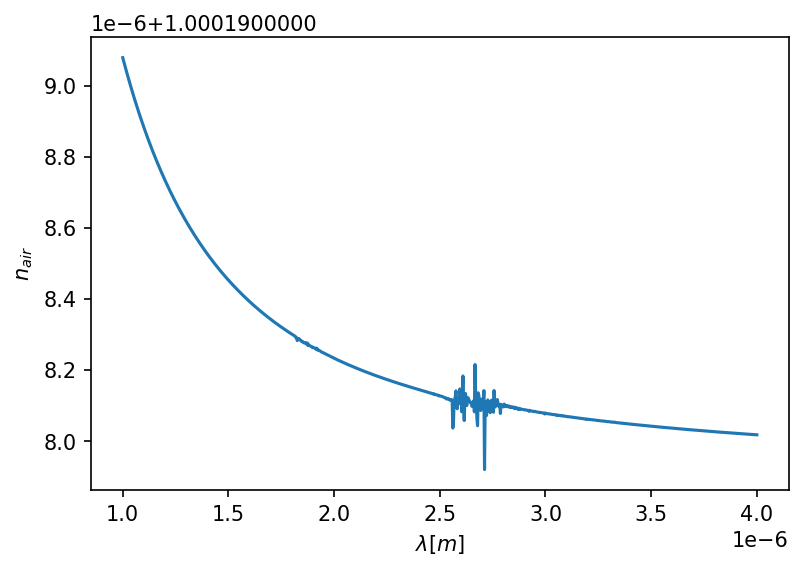

In [7]:
lambs = np.linspace(1.e-6, 4.e-6, 1000)
plt.figure(dpi=150)
plt.plot(lambs, wet_atmo.get_Nair(lambs, add=1.))
plt.xlabel(f"$\\lambda [m]$")
plt.ylabel(f"$n_{{air}}$")
plt.show()

In [8]:
n2, n1 = sp.symbols("n_{2}, n_{1}", real=True, positive=True)
theta1 = sp.symbols("theta_1", real=True, positive=True)
theta2_e = sp.atan((n2-n1)*sp.tan(theta1))
theta2_n = sp.lambdify((theta1, n2, n1),theta2_e)
dtheta_e = theta2_e - theta1
dtheta_n = sp.lambdify((theta1, n2, n1), dtheta_e)
dtheta_n.__doc__ = \
    """
    Returns the angle of relative deviation of the beam
    seing the index n2 compared to the beam seing the 
    index n1.
    
    **Parameters:**
    
    * theta1 : Angle to zenith for the main beam (used for guiding)
    * n2     : The refractive index for the beam of interest
    * n1     : The refractive index for the reference beam
    """

In [9]:
#from IPython import display
sf.utilities.fprint(dtheta_e, "\\theta_2 = ")

<IPython.core.display.Math object>

In [10]:
# For an angle to zenith 
theta2_n(0.5, n_airn[0], n_airn[-1])*un.rad.to(un.mas)

2.736582591138209e+00

## Defining the Asgard bands

In [11]:
Y0 = (1020,120)
J0 = (1220, 213)
H0 = (1630, 307)
K0 = (2190, 390)
L0 = (3450, 472)
def band2range(couple, n=3, unit=un.nm, value=True):
    """
    Convert an wavelength range from a couple (center, fwhm) to 
    a range of n (default 3) subchannels.
    
    **Parameters:**
    
    * couple  : defintion of the band (center, fwhm)
    * n       : The number of points in the range
    * unit    : An astropy.unit unit (default unit.nm)
    * value   : return a value if True (default), or a
      quantity if false
    """
    center = couple[0]
    fwhm = couple[1]
    start = center - fwhm/2
    end = center + fwhm/2
    therange = np.linspace(start, end, n)*unit.to(un.m)
    if value:
        return therange
    else:
        return therange*un.m

In [12]:
Y_band = band2range(Y0)
J_band = band2range(J0)
H_band = band2range(H0)
K_band = band2range(K0)
L_band = band2range(L0)
Lp_band = np.linspace(3.5e-6, 4.0e-6, 3)

lamb_asgard = {"bifrost y":Y_band,
               "bifrost J":J_band,
               "baldr H":H_band,
               "heimdallr K":K_band,
               "hi5 L'":Lp_band}

#dth_bifrost = theta2_n(0.5, lamb_asgard["bifrostj"], np.mean(lamb_asgard["baldrh"]))
#dth_baldr = theta2_n(0.5, lamb_asgard["baldrh"], np.mean(lamb_asgard["baldrh"]))
#dth_heimdallr = theta2_n(0.5, lamb_asgard["heimdallr"], np.mean(lamb_asgard["baldrh"]))
#dth_hi5 = theta2_n(0.5, lamb_asgard["bifrostj"], np.mean(lamb_asgard["baldrh"]))



## Creating a colors for markers

Both for a rainbow display and using the standard matplotlib "Cx" series

In [13]:
cmap = plt.matplotlib.cm.jet
dth = {}
colors = {}
colorsC = {}
positions = {}
for i, akey in enumerate(lamb_asgard.keys()):
    #dth[akey] = theta2_n(0.5, lamb_asgard[akey], np.mean(lamb_asgard["baldrh"]))
    colorsC[akey] = f"C{i}"
    #print(akey)
    colors[akey] = cmap(sf.utilities.trois(lamb_asgard[akey], 1.0e-6, 4.0e-6))
    #print(cmap(sf.utilities.trois(lamb_asgard[akey], 1.0e-6, 4.0e-6)))

## Creating the series of angular offset.

In [14]:
az = []
zenith_angles = []
par = []
dths = []
for i, at in enumerate(asim.sequence):
    asim.point(at, asim.target, refresh_array=True, )
    par.append(asim.obs.PA)
    az.append(asim.obs.altaz)
    #altaz, pa = asim.obs.get_position(asim.target, at, )
    #az.append(altaz)
    #par.append(pa)
    zenith_angle = (np.pi/2)*un.rad - asim.obs.altaz.alt.to(un.rad)
    zenith_angles.append(zenith_angle)
    dth = {}
    for j, akey in enumerate(lamb_asgard.keys()):
        n_band = wet_atmo.get_Nair(lamb_asgard[akey])
        dth[akey] = theta2_n(zenith_angle.value, n_band,
                             np.mean(wet_atmo.get_Nair(lamb_asgard["baldr H"])))
    dths.append(dth)
    #print(asim.obs.PA)
    #print(asim.obs.altaz)
    

## Including the parallactic angle

Here, the plots are given projected on sky. In practice (from what I understand), NAOMI operates in fixed pupil mode, and GPAO will not (pupil rotates with the mount). I don't know yet **where to find the field/pupil rotation law for GPAO**.

/lhome/romain/miniconda3/envs/math1/lib/python3.9/site-packages/astroplan-0.8-py3.9.egg/astroplan/plots/time_dependent.py:399: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot_date(time.plot_date, masked_altitude, label=target_name, **style_kwargs)


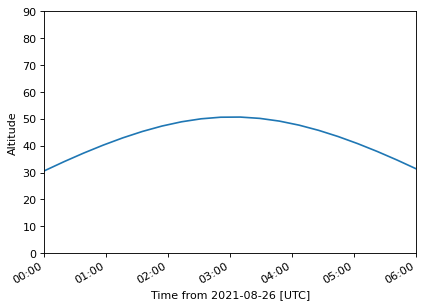

In [15]:
fig = plt.figure(dpi=80)
sf.obs.astroplan.plots.plot_altitude(asim.target, asim.obs.observatory_location, asim.sequence)
plt.show()

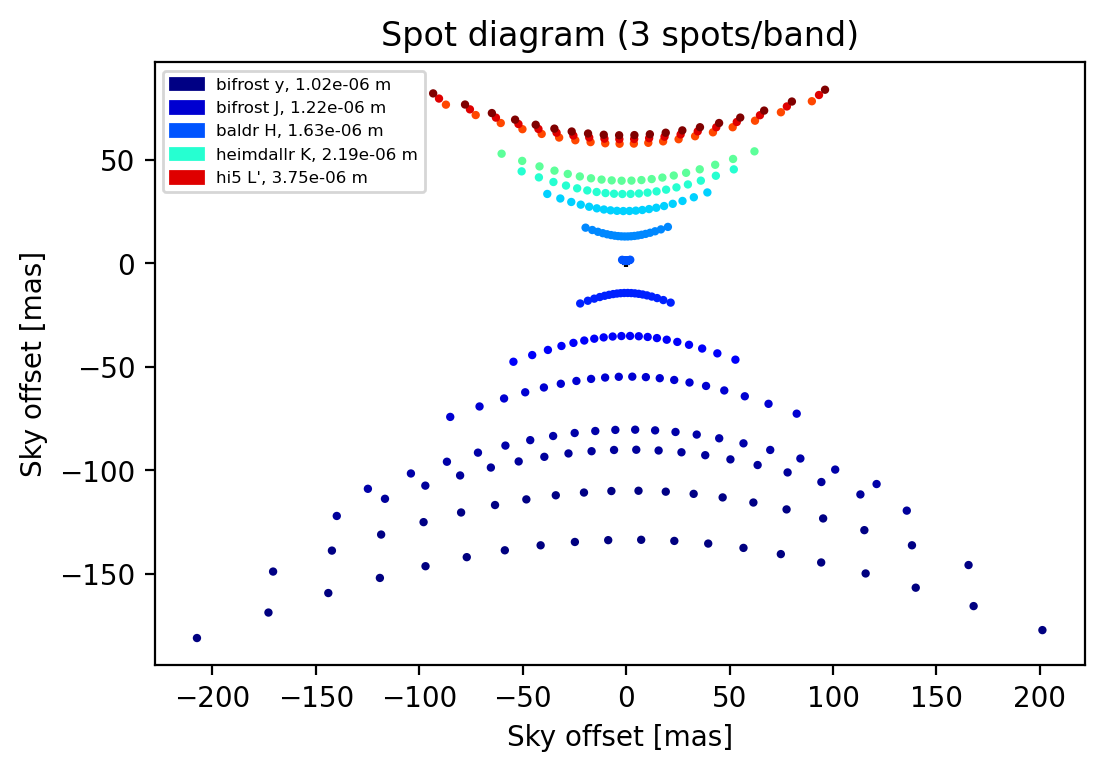

In [16]:
#D = asim.injector.pdiam
D = 8.
fig = plt.figure(dpi=200)
plt.scatter(0,0, marker="+", c="k", s=10)
lastpos = {}
for i, at in enumerate(asim.sequence[:]):
    patches = []
    for j, akey in enumerate(lamb_asgard.keys()):
        xs, ys = dths[i][akey]*np.sin(par[i].value)*un.rad.to(un.mas),\
                    dths[i][akey]*np.cos(par[i].value)*un.rad.to(un.mas)
        #print(akey, xs,)
        alabel = akey
        plt.scatter(xs, ys, c=colors[akey], s=4, label=alabel)
        lastpos[akey] = dths[i][akey]*np.sin(par[i].value*1.1)*un.rad.to(un.mas),\
                    dths[i][akey]*np.cos(par[i].value*1.1)*un.rad.to(un.mas)
        patches.append(plt.matplotlib.patches.Patch(color=colors[akey][1],
                                  label=f"{akey}, {lamb_asgard[akey][1]:.2e} m"))
    #print(dths[i]["bifrost y"])
        
#for akey in lamb_asgard.keys():
#    for i, awl in enumerate(lamb_asgard[akey]):
#        plt.text(lastpos[akey][0][i], lastpos[akey][1][i], f"{awl*1e6:.2f}", fontsize=4)
#

plt.legend(handles=patches, fontsize=6)
plt.gca().set_aspect("equal")
plt.title("Spot diagram (3 spots/band)")
plt.xlabel("Sky offset [mas]")
plt.ylabel("Sky offset [mas]")
#plt.xlim(-200,200)
#plt.ylim(-100,200)
plt.show()

## Including resolution element size

This plot is done for the first pointing in the sequence (lowest elevation).

bifrost y [-207.47178919 -170.661921   -139.87661974]
bifrost J [-124.83184464  -85.02267482  -54.47482151]
baldr H [-22.20122471   1.99938698  20.20183768]
heimdallr K [39.2847198  52.06440352 62.04591102]
hi5 L' [89.79870089 93.24964295 96.16495945]


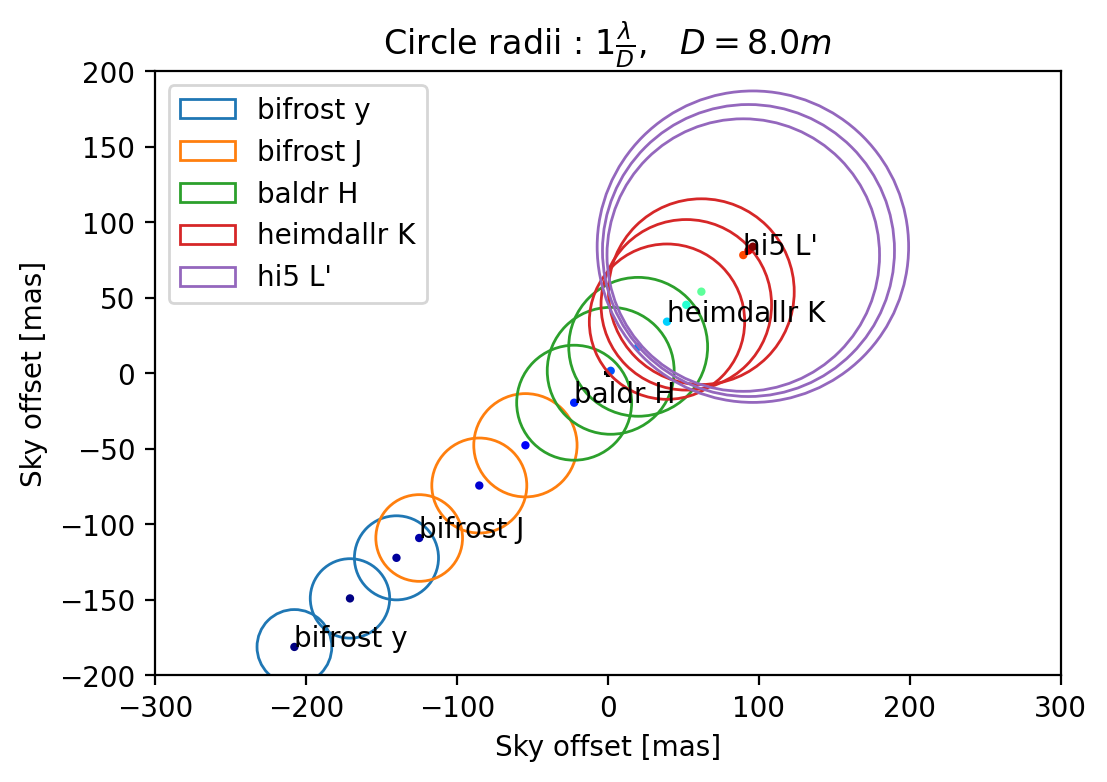

In [17]:
D = asim.injector.pdiam
fig = plt.figure(dpi=200)
plt.scatter(0,0, marker="+", c="k", s=10)
lastpos = {}
for i, at in enumerate(asim.sequence[:1]):
    for j, akey in enumerate(lamb_asgard.keys()):
        xs, ys = dths[i][akey]*np.sin(par[i].value)*un.rad.to(un.mas),\
                    dths[i][akey]*np.cos(par[i].value)*un.rad.to(un.mas)
        print(akey, xs,)
        plt.scatter(xs, ys, c=colors[akey], s=4)
        lastpos[akey] = (xs, ys)
        patches = []
        for k in range(xs.shape[0]):
            radius = (lamb_asgard[akey][k]/D)*un.rad.to(un.mas)
            #print(radius)
            if k == 0:
                alabel = akey
            else:
                alabel = None
            circle = plt.Circle((xs[k], ys[k]), radius=radius, fill=False,
                                color=colorsC[akey], label=alabel)
            fig.axes[0].add_artist(circle,)
        
for akey in lamb_asgard.keys():
    plt.text(lastpos[akey][0][0], lastpos[akey][1][0], akey)

plt.legend()
plt.gca().set_aspect("equal")
plt.xlim(-300,300)
plt.ylim(-200,200)
plt.title(f"Circle radii : $1\\frac{{\\lambda}}{{D}}$,   $D = {D:.1f} m$")
plt.xlabel("Sky offset [mas]")
plt.ylabel("Sky offset [mas]")
plt.show()